<a href="https://colab.research.google.com/github/sgalrot/simpsons_compression/blob/main/simpsons_compression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Images Compression

### Some Colab Setup

Installing kaggle and downloading the dataset

You should download the **kaggle.json** file from your kaggle account and upload it once prompted with "upload file"

In case you are using local machine, just (not tested):

1) `pip install`

2) download dataset using `kaggle datasets download -d kostastokis/simpsons-faces`

In [21]:
from os.path import exists, expanduser
if not exists(expanduser('~/.kaggle/kaggle.json')):
  !pip install -q kaggle # type: ignore
  from google.colab import files 
  files.upload()
  !mkdir ~/.kaggle # type: ignore
  !cp kaggle.json ~/.kaggle/ # type: ignore
  !chmod 600 ~/.kaggle/kaggle.json # type: ignore

# Downloading the dataset
!kaggle datasets download -d kostastokis/simpsons-faces
!mkdir dataset
!unzip simpsons-faces.zip -d ./dataset/

simpsons-faces.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘dataset’: File exists
Archive:  simpsons-faces.zip
replace ./dataset/cropped/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from torchvision import datasets
from skimage.transform import resize
from skimage.io import imread, imsave


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Loading the Dataset

We will use again the digits dataset from the last assignment.

In [23]:
from os.path import split
import glob
path = 'dataset'
path_img = list(glob.glob(path+'/cropped/*.png'))

labels = list(map(lambda x:split(split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)

# labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path
0,dataset/cropped/7386.png
1,dataset/cropped/5606.png
2,dataset/cropped/6739.png
3,dataset/cropped/4109.png
4,dataset/cropped/8949.png


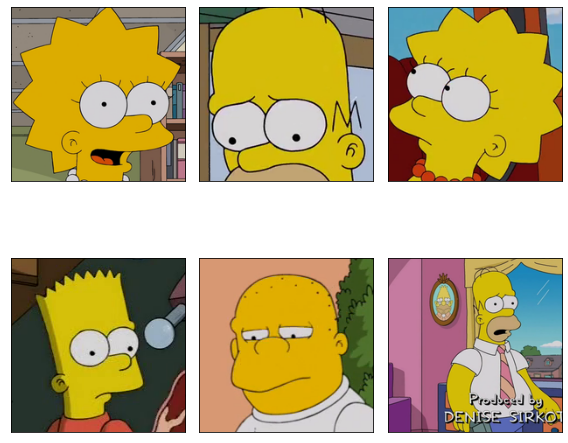

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(imread(data.File_Path[i]))
plt.tight_layout()
plt.show()

In [25]:
images = data.File_Path
type(images) 

pandas.core.series.Series

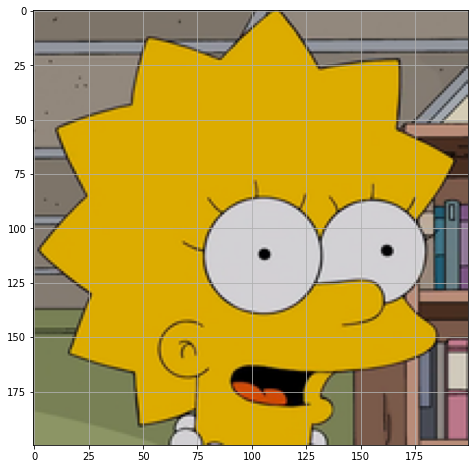

In [26]:
image_sample = imread(images[0])
plt.imshow(image_sample)
x_dim, y_dim, _ = image_sample.shape

In [27]:
image_resize_shape = (64, 64, 3)
x = np.array([resize(imread(file_path), image_resize_shape, anti_aliasing=True) 
                for file_path in data.File_Path])

## Train-Test split

In [28]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 90% train / 10% test
train_indices = indices[:int(0.9 * n_samples)]
test_indices = indices[int((0.9) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
x_train = x[train_indices]
x_test = x[test_indices]

#Loading the Autoencoder

In [29]:
class CNN_AE(torch.nn.Module):

    def __init__(self):   
        super(CNN_AE, self).__init__()
        
        ## Defining the convolutional and pooling layers with their parameters
        ## ===========================================================================
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.t_conv3 = torch.nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.t_conv2 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.t_conv1 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = x.transpose(1,3)  # 3*64*64
        z = self.conv1(x) # 64*64*64
        z = torch.nn.functional.relu(z)
        z = self.pool(z)  # 64*32*32
        z = self.conv2(z) # 64*16*16
        z = torch.nn.functional.relu(z)
        z = self.conv3(z) # 16*8*8
        z = torch.nn.functional.relu(z)
        y = z
        
        # Decoder
        z = self.t_conv3(z)
        z = torch.nn.functional.relu(z)
        z = self.t_conv2(z)
        z = torch.nn.functional.relu(z)
        z = torch.nn.functional.upsample(z, scale_factor=2, mode='nearest')
        z = self.t_conv1(z)
        z = torch.nn.functional.sigmoid(z)
        return z.transpose(1,3), y


model = CNN_AE()
print(model)

CNN_AE(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv3): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv1): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [30]:
PATH = './simpsons_autoencoder.pth'
model = CNN_AE()
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
x_train.shape

(8889, 64, 64, 3)

In [47]:
x, y = model(torch.tensor(x_train[:1500]).float())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [48]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
with torch.no_grad():
  tsne = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(y.numpy().reshape(y.shape[0], -1))

In [49]:
tsne.shape

(1500, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


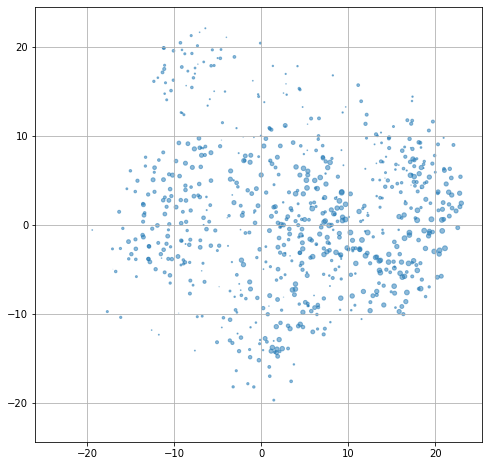

In [50]:
plt.scatter(tsne[:,0], tsne[:,1], tsne[:,2], alpha=0.5)

In [53]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(tsne)

In [54]:
kmeans.labels_

array([3, 6, 6, ..., 2, 2, 4], dtype=int32)

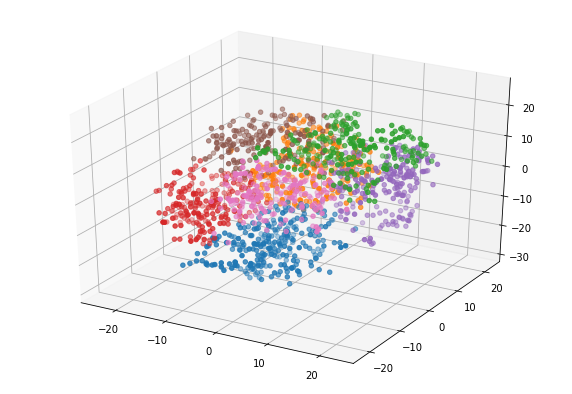

In [61]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
for i in range(7):
  ax.scatter3D(tsne[kmeans.labels_==i, 0], tsne[kmeans.labels_==i, 1], tsne[kmeans.labels_==i, 2], s=20, label='{}'.format(i))

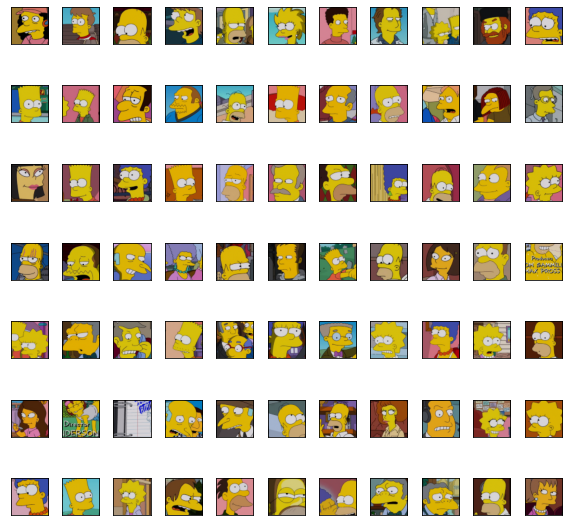

In [112]:
fig, axes = plt.subplots(nrows=7, ncols=11, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  indices = np.where(kmeans.labels_==np.floor(i%7))
  ax.imshow(x_train[indices[0][int(np.floor(i / 7))]])
plt.tight_layout()
plt.show()

## Summary
We tried to do clustering, after showing the grid with 7 different clusters we can't arrive any smart conclusion except that the encoded layer contains too many dimensions so there is no visible division between clusters.